# Курс "Практикум по математической статистике"
# 3 курс ФПМИ МФТИ, осень 2024


In [ ]:
# Matplotlib needed to correctly display suptitles,
# as well as some other minor things.
# I thought I might as well ensure everything is up to date
%pip install --upgrade matplotlib numpy scipy statsmodels

In [2]:
from __future__ import annotations
import typing
import abc
import dataclasses
import itertools

In [473]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import seaborn as sns
# from scipy.stats import gamma, rayleigh, beta, poisson, binom, norm, laplace
from scipy.integrate import quad
# from scipy.special import gamma
from scipy.special import comb

sns.set(style='darkgrid')
%matplotlib inline

In [7]:
np.random.seed(42)

**Условие задания**: После полугода лишений и страданий Великая Ордалия наконец добралась до врат Голготтерата и бросила вызов нечестивому консульту. Главное оружие в борьбе с чудовищами --- холодный точный рассчёт и идеальное планирование.

Вам, оставшимся выжившим после перехода через пустоши предстоит взять на себя роль тактиков Аспект-Императора, рассчитать все риски и придумать оптимальный план штурма.

Пусть Гнозис Вам благоволит и удачи!

**Гайд, как моделировать оценки**:

В разных задачах Вы будете видеть ключевое слово "смоделируйте". Для моделирования оценки необходимо сгенерировать большое число выборок из одного распределения, построить по каждой из выборок оценку и получить выборку оценок. Далее по выборке оценок можно построить гистограмму или эмпирическую функцию распределения, и сделать выводы о распределении оценок.

Как мы знаем по теореме Гливенко-Кантелли, эмпирическая функция распределения сходится к реальной, и, при некоторых условиях, гистограмма сходится к плотности, если она существует.

## Задача 1. Статистики и оценки. (30 баллов)




**Как оценивается задача:** 10 баллов за нахождение и моделирование оценок информативными графиками, 10 баллов за подсчёт теоретических и эмпирических рисков и сравнение, 10 баллов за анализ состоятельности и асимптотической нормальности.

Для распределения Релэя https://en.wikipedia.org/wiki/Rayleigh_distribution с плотностью $p_{\sigma}(x) = \frac{x}{\sigma^2}exp(-\frac{x^2}{\sigma^2}) I(x \geq 0)$ предложите следующие оценки параметра $\sigma$:

- Оценка методом моментов
- Оценка максимального правдоподобия
- Оценка медианой

Решение: (Только ответы, решения покажу на сдаче)

- Оценка методом моментов: $\hat{\sigma} = \overline{X}\sqrt{\frac{2}{\pi}}$
- Оценка максимального правдоподобия: $\hat{\sigma} = \sqrt{\frac{\sum_{i=1}^{n}X_i^2}{2n}}$
- Оценка медианой: $\hat{\sigma} = \frac{m}{2ln2}$, где m -- выборочная медиана.

Запишите формулу риска каждой оценки в виде интеграла и вычислите его аналитически или численно при помощи scipy.integrate.quad для размера выборки равного 10.

Формулы рисков (матожидание функции от с.в. -- это интеграл от произведения плотности с.в. на с.в.):

- $Risk(\hat{\sigma}_{мм}) = \mathbb{E}\left(\bar{X} \cdot \sqrt{\frac{2}{\pi}} - \sigma\right)^2 = \frac{\sigma^2 (4 - \pi)}{10\pi} $
- $Risk(\hat{\sigma}_{мп}) = \sqrt{\frac{Y}{2n}}, Y \sim Gamma(n, \sigma^2 / 2)$
- $Risk(\hat{\sigma}_{м}) = \frac{m}{\sqrt{2ln2}}$

In [240]:
n = 10
sigma = 1
theta = (sigma ** 2) * 2
mse_moments = (4 - np.pi) / (n * np.pi)
print(f"Риск при методе моментов: {mse_moments:.6f}")

def integrand_mle(x):
    return (np.sqrt(x / (2 * n)) - sigma) ** 2 * gamma.pdf(x, a=n, scale=theta)


mse_mle, _ = quad(integrand_mle, 0, np.inf)
print(f"Риск при методе максимального правдоподобия: {mse_mle:.6f}")


# Это грубо посчитанная плотность медианы, так как для правильного подсчета нужно посчитать свертку. Или есть другой способ, но я не могу его вспомнить
def pdf_median(x, n=10):
    """
        Это грубо посчитанная плотность медианы, так как
        для правильного подсчета нужно посчитать свертку.
        Или есть другой способ, но я не могу его вспомнить
    """
    
    F = rayleigh.cdf(x, scale=sigma)
    f = rayleigh.pdf(x, scale=sigma)
    p_5 = comb(n, 5) * f * (F) ** (5 - 1) * (1 - F) ** (n - 5)
    p_6 = comb(n, 6) * f * (F) ** (6 - 1) * (1 - F) ** (n - 6)
    return (p_5 + p_6) 



def integrand_median(x):
    return (x / sqrt(2 * np.log(2)) - sigma) ** 2 * pdf_median(x, n)


mse_median, _ = quad(integrand_median, 0, np.inf)
print(f"Риск при оценкой медианой: {mse_median:.6f}")

Риск при методе моментов: 0.027324
Риск при методе максимального правдоподобия: 0.024834
Риск при оценкой медианой: 0.019798


Посчитайте эмпирический риск каждой оценки для размера выборки N = 100

In [241]:
N = 100
num_sim = 100
samples = sps.rayleigh.rvs(scale=sigma, size=(num_sim, N))

sigma_hat_moments = np.mean(samples, axis=1) * np.sqrt(2 / np.pi)
sigma_hat_mle = np.sqrt(np.mean(samples**2, axis=1) / 2)
sigma_hat_median = np.median(samples, axis=1) / np.sqrt(2 * np.log(2))

errors_moments = (sigma_hat_moments - sigma) ** 2
errors_mle = (sigma_hat_mle - sigma) ** 2
errors_median = (sigma_hat_median - sigma) ** 2

mse_moments = np.mean(errors_moments)
mse_mle = np.mean(errors_mle)
mse_median = np.mean(errors_median)

print(f"Эмпирический риск при методе моментов: {mse_moments:.6f}")
print(f"Эмпирический риск при методе максимального правдоподобия: {mse_mle:.6f}")
print(f"Эмпирический риск при оценке медианой: {mse_median:.6f}")

Эмпирический риск при методе моментов: 0.003238
Эмпирический риск при методе максимального правдоподобия: 0.002986
Эмпирический риск при оценке медианой: 0.005674


Промоделируйте каждую оценку для 100 выборок размера N = 100 и постройте эмпирическое распределение каждой оценки.

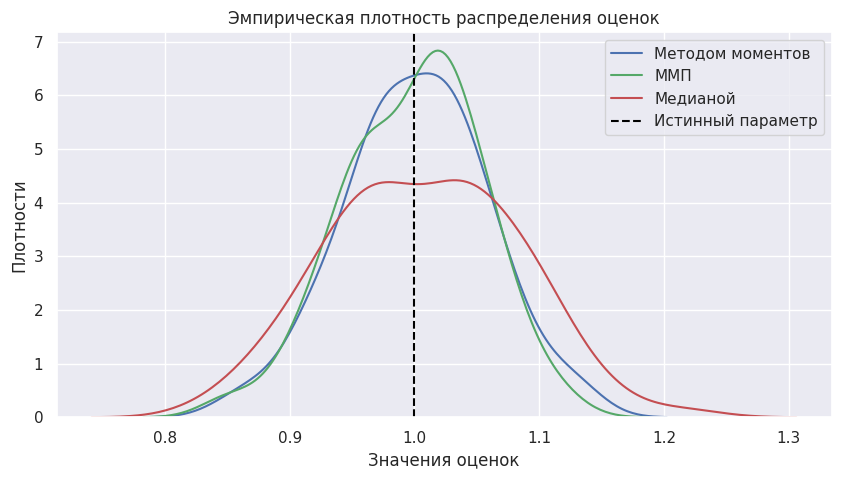

In [242]:
with sns.plotting_context("notebook"):
    plt.figure(figsize=(10, 5))
    
    sns.kdeplot(sigma_hat_moments, color='b', label='Методом моментов')
    sns.kdeplot(sigma_hat_mle, color='g', label='ММП')
    sns.kdeplot(sigma_hat_median, color='r', label='Медианой')
    plt.axvline(x=sigma, color='black', linestyle='--', label='Истинный параметр')
    
    plt.title('Эмпирическая плотность распределения оценок')
    plt.xlabel('Значения оценок')
    plt.ylabel('Плотности')
    plt.legend()

Исходя из графиков, можно ли делать выводы о состоятельности и асимптотической нормальности оценок? Будут ли оценки состоятельными и асимптотически нормальными в теории? Сошлитесь на соответствующие теоремы и предложите теоретические выкладки ниже.

Ответ: 

О состоятельности просто по графику плотности распределения оценок тяжело что-то сказать. Про асимптотическую нрмальность, на самом деле, тоже, так как нужно построить эмпирическую плотность распределения статистики $\sqrt{n}\left(\widehat\sigma - \sigma\right)$. Но вот теория нам здесь поможет. 

1. Асипточтеская нормальность

    - Оценка методом моментов асимптотичеки нормальна по Теореме 3.2 на стр. 16 конспекта лекций М.П.Савлова, 2023 года (ну и    просто следует из ЦПТ)
    - Оценка методом максимального правдоподобия асимптотичеки нормальна по следствию из Теоремы 3.15 на стр. 39 конспекта лекций М.П.Савлова, 2023 года
    - Оценка медианой асимптотичеки нормальна по Теореме 3.3 о выборочных квантилях на стр. 17 конспекта лекций М.П.Савлова, 2023 года

2. Состоятельность.

    - Оценка методом моментов состоятельна по Теореме 3.1 на стр. 15 конспекта лекций М.П.Савлова, 2023 года
    - Оценка методом максимального правдоподобия состоятельна, так как она асимптотичеки нормальна 
    - Оценка медианой состоятельна, так как она асимптотичеки нормальна



Сравните три оценки в равномерном и асимптотическом подходе. Сделайте вывод о качестве оценок.

В равномерном подходе с квадратичной функцией потерь мы уже сравнили оценки (эмпирически) и получили, то лучше всех себя показал ММП, а хуже -- оценка медианой. Сравним теперь оценки в асимпточеском подходе для этого нужно посчитать эмпирическую плотность распределения статистики $\sqrt{n}\left(\widehat\sigma - \sigma\right)$, посчитать выборочную дисперсию для каждой оценки и сравнить их. Только в этот раз возьмем побольше выборок.

In [243]:
N = 1000
num_sim = 10000
samples = sps.rayleigh.rvs(scale=sigma, size=(num_sim, N))

sigma_hat_moments = np.mean(samples, axis=1) * np.sqrt(2 / np.pi)
sigma_hat_mle = np.sqrt(np.mean(samples**2, axis=1) / 2)
sigma_hat_median = np.median(samples, axis=1) / np.sqrt(2 * np.log(2))

as_var_moments = np.var(np.sqrt(num_sim) * (sigma_hat_moments - sigma))
as_var_mle = np.var(np.sqrt(num_sim) * (sigma_hat_mle - sigma))
as_var_median = np.var(np.sqrt(num_sim) * (sigma_hat_median - sigma))


print(f"Асимптотическая дисперсия оценок методом моментов: {as_var_moments:.6f}")
print(f"Асимптотическая дисперсия оценок методом максимального правдоподобия: {as_var_mle:.6f}")
print(f"Асимптотическая дисперсия оценок медианой: {as_var_median:.6f}")

Асимптотическая дисперсия оценок методом моментов: 2.762952
Асимптотическая дисперсия оценок методом максимального правдоподобия: 2.523614
Асимптотическая дисперсия оценок медианой: 5.317645


In [66]:
# with sns.plotting_context("notebook"):
#     plt.figure(figsize=(10, 5))
    
#     sns.kdeplot(np.sqrt(num_sim) * (sigma_hat_moments - sigma), color='b', label='Методом моментов')
#     sns.kdeplot(np.sqrt(num_sim) * (sigma_hat_mle - sigma), color='g', label='ММП')
#     sns.kdeplot(np.sqrt(num_sim) * (sigma_hat_median - sigma), color='r', label='Медианой')

**Вывод:**

Итак, мы рассмотрели три оценки параметра $\sigma$ распределения Релэя (ОММ, ММП, оценка медианой). Все они оказались состоятельными и асимптотически нормальными. Также, мы эмпирически сравнили эти оценки, и в равномерном подходе победила ММП, а в асимптотическом -- снова ММП.

## Задача 2. Моделирование (10 баллов)




Сформулируйте и запишите ниже Центральную Предельную теорему и Усиленный Закон Больших Чисел. Не забудьте про условия теорем!

Ответ:

ЦПТ:

Пусть $ X_1, X_2, \ldots $ — независимые одинаково распределённые случайные величины с конечными математическим ожиданием $ \mu = \mathbb{E}X_i $ и дисперсией $ \sigma^2 = \mathbb{D}X_i $. Тогда

$$
\frac{\sum_{i=1}^{n}X_i - n\mu}{\sqrt{n \sigma^2}} \xrightarrow[n \to \infty]{d} \mathcal{N}(0, 1)
$$

УЗБЧ:

Пусть $ X_1, X_2, \ldots $ — независимые одинаково распределённые случайные величины с конечным математическим ожиданием $ \mu = \mathbb{E}X_i $. Тогда

$$
\frac{\sum_{i=1}^{n}X_i}{n} \xrightarrow[n \to \infty]{P п.н.} 0
$$


Численно проверьте верность теорем выше. Для доказательства того, что распределение является нормальным (в ЦПТ) используйте QQ-plot и гистограмму.

На 10 баллов необходимо показать, что теоремы верны, когда верны их условия и могут нарушаться для случайных величин, для которых условия теорем не верны. Приведите хотя бы по одному примеру величин, для которых ЦПТ и УЗБЧ не выполняются, покажите какие условия теоремы не верны и моделированием покажите, что теорема не выполняется.

Выберем экспоненциальное распределение с матожиданием, равным единице. Для начала докажем, что теоремы выполняются.

In [341]:
lambda_param = 1.0
mu = 1 / lambda_param
sigma = 1 / lambda_param

n = 1000
experiments = 1000

samples = sps.expon.rvs(scale=mu, size=(experiments, n))
sample_means = np.mean(samples, axis=1)

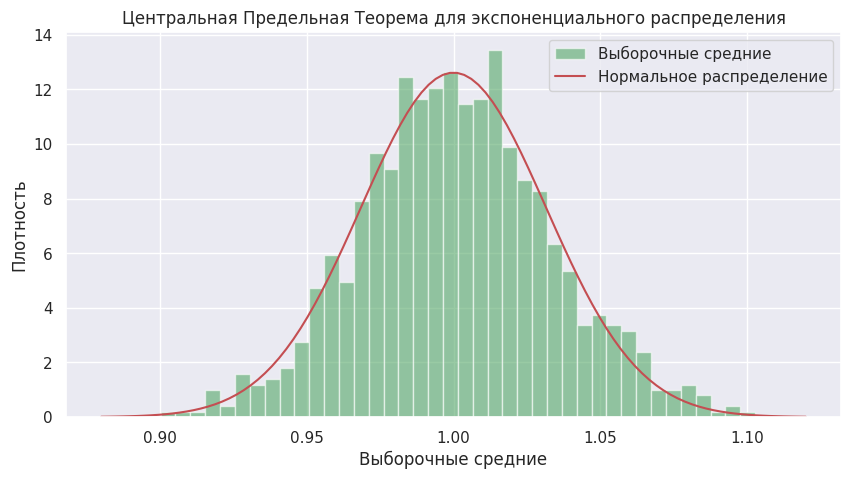

In [342]:
with sns.plotting_context("notebook"):
    plt.figure(figsize=(10, 5))
    
    plt.hist(sample_means, bins=40, density=True, alpha=0.6, color='g', label='Выборочные средние')
    # xmin, xmax = plt.xlim()
    # x = np.linspace(xmin, xmax, 100)
    x = np.linspace(0.88, 1.12, 100)
    plt.plot(x, sps.norm.pdf(x, loc=mu, scale=sigma/np.sqrt(n)), 'r', label='Нормальное распределение')
    
    plt.title('Центральная Предельная Теорема для экспоненциального распределения')
    plt.xlabel('Выборочные средние')
    plt.ylabel('Плотность')
    plt.legend()

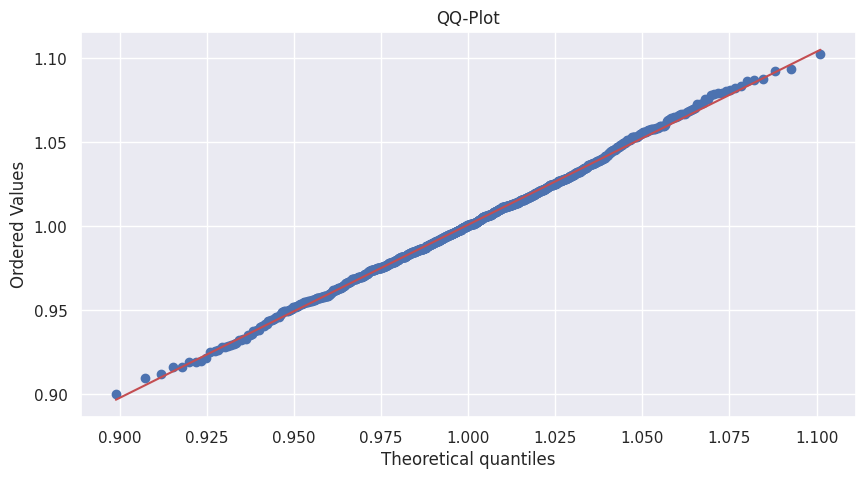

In [343]:
with sns.plotting_context("notebook"):
    plt.figure(figsize=(10,5))
    sps.probplot(sample_means, dist="norm", sparams=(mu, sigma/np.sqrt(n)), plot=plt)
    plt.title('QQ-Plot')
    # plt.ylim((-300, 300))

Как видим, ЦПТ выполняется. Далее УЗБЧ

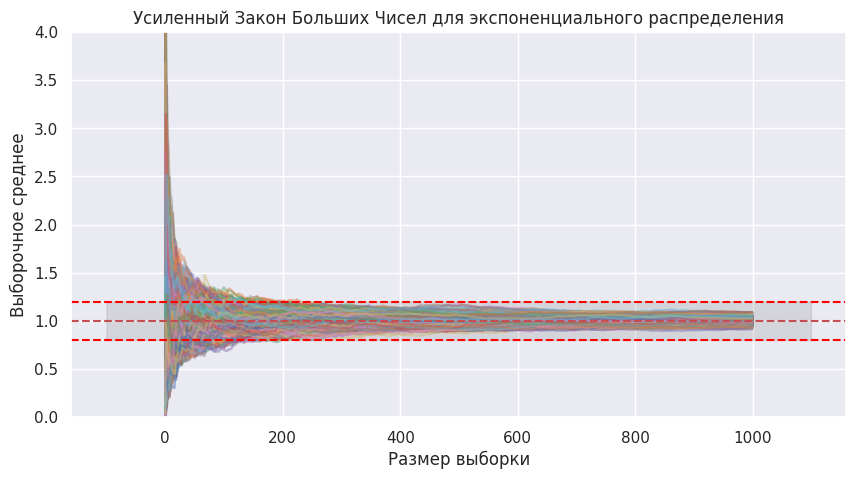

In [349]:
# sample = sps.expon.rvs(scale=mu, size=n)
# cumulative_means = np.cumsum(sample) / np.arange(1, len(sample) + 1)

# with sns.plotting_context("notebook"):
#     plt.figure(figsize=(10, 5))
#     plt.plot(cumulative_means, label='Выборочное среднее', color='g')
#     plt.axhline(y=mu, color='r', linestyle='--', label='Теоретическое матожидание')
#     plt.title('Усиленный Закон Больших Чисел для экспоненциального распределения')
#     plt.xlabel('Размер выборки')
#     plt.ylabel('Выборочное среднее')
#     plt.legend()

epsilon = 0.2
samples = sps.expon.rvs(scale=mu, size=(n, n))
cumsums = np.cumsum(samples, axis=1)

with sns.plotting_context("notebook"):
    plt.figure(figsize=(10, 5))
    for i in range(n):
        plt.plot(cumsums[i] / np.arange(1, n + 1), alpha=0.5)
    plt.axhline(
        y=mu + epsilon,
        color="red",
        linestyle="--",
        label=r"Границы $\epsilon$-окрестности",
    )
    plt.axhline(y=mu - epsilon, color="red", linestyle="--")
    plt.fill_between(
        range(-100, n + 100),
        mu - epsilon,
        mu + epsilon,
        color="gray",
        alpha=0.2,
    )
    plt.axhline(y=mu, color='r', linestyle='--', label='Теоретическое матожидание')
    plt.title('Усиленный Закон Больших Чисел для экспоненциального распределения')
    plt.xlabel('Размер выборки')
    plt.ylabel('Выборочное среднее')
    plt.ylim((0,4))

УЗБЧ, как видим, тоже выполняется. Перейдем к случаям, когда условия теорем и, как следствие, сами теоремы, не выполняются. Начнем с ЦПТ. Возьмем распределение Коши, у которого не определено матожидание. Тут уже не получится проверить напрямую сходимость к нормальному распредленеию, поэтому используемм сразу QQ-plot.

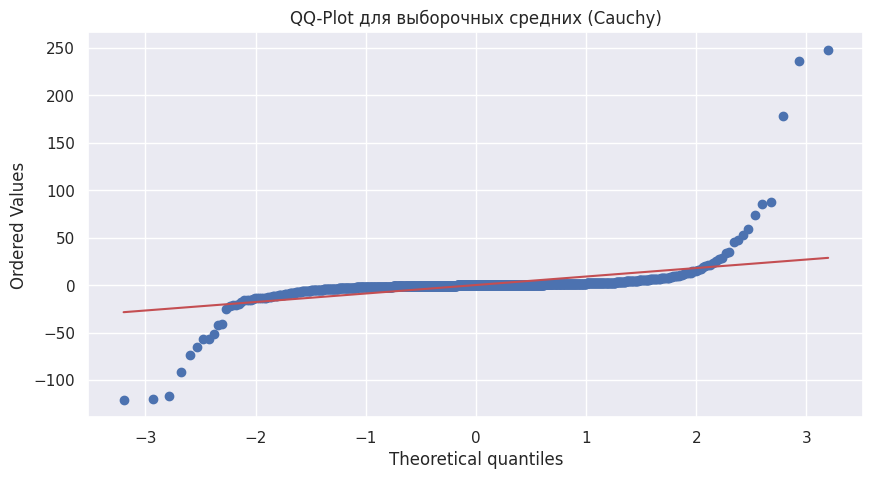

In [123]:
samples_cauchy = sps.cauchy.rvs(loc=0, scale=1, size=(experiments, n))
sample_means_cauchy = np.mean(samples_cauchy, axis=1)

with sns.plotting_context("notebook"):
    plt.figure(figsize=(10,5))
    sps.probplot(sample_means_cauchy, dist="norm", plot=plt)
    plt.title('QQ-Plot для выборочных средних (Cauchy)')
    # plt.ylim((-300, 300))

Ясно понятно, что нормального распределения здесь не наблюдается. Проверим, наконец, УЗБЧ.

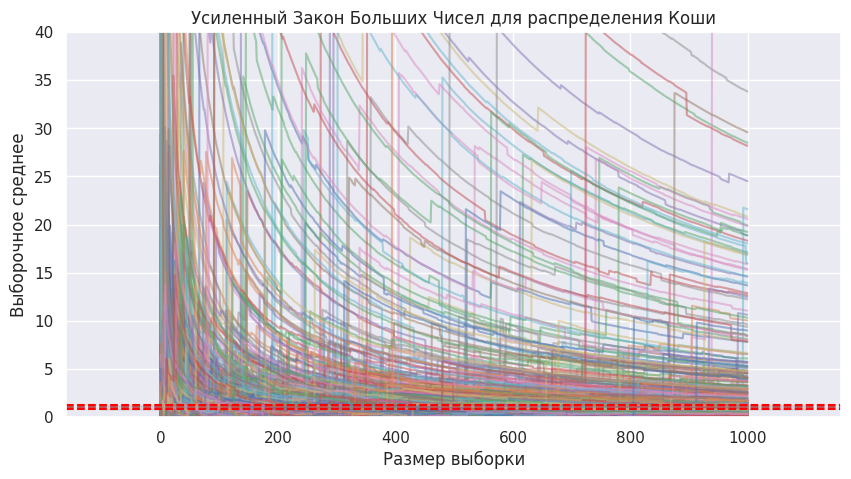

In [352]:
# sample_cauchy = sps.cauchy.rvs(loc=0, scale=1, size=n)
# cumulative_means_cauchy = np.cumsum(sample_cauchy) / np.arange(1, len(sample_cauchy) + 1)

# with sns.plotting_context("notebook"):
#     plt.figure(figsize=(10, 5))
#     plt.plot(cumulative_means_cauchy, label='Выборочное среднее', color='g')
#     plt.axhline(y=mu, color='r', linestyle='--', label='Теоретическое матожидание')
#     plt.title('Усиленный Закон Больших Чисел для распределения Коши')
#     plt.xlabel('Размер выборки')
#     plt.ylabel('Выборочное среднее')
#     plt.legend()


epsilon = 0.2
samples = sps.cauchy.rvs(loc=0, scale=1, size=(n, n))
cumsums = np.cumsum(samples, axis=1)

with sns.plotting_context("notebook"):
    plt.figure(figsize=(10, 5))
    for i in range(n):
        plt.plot(cumsums[i] / np.arange(1, n + 1), alpha=0.5)
    plt.axhline(
        y=mu + epsilon,
        color="red",
        linestyle="--",
        label=r"Границы $\epsilon$-окрестности",
    )
    plt.axhline(y=mu - epsilon, color="red", linestyle="--")
    plt.fill_between(
        range(-100, n + 100),
        mu - epsilon,
        mu + epsilon,
        color="gray",
        alpha=0.2,
    )
    plt.axhline(y=mu, color='r', linestyle='--', label='Теоретическое матожидание')
    plt.title('Усиленный Закон Больших Чисел для распределения Коши')
    plt.xlabel('Размер выборки')
    plt.ylabel('Выборочное среднее')
    plt.ylim((0,40))

Результат очевиден.

__Вывод__:

Итак, мы проверили, что ЦПТ и УЗБЧ верны, когда выполняются условия теорем и необязательно верны, когда условия не выполнены.

## Задача 3. Метод моментов (10 баллов)


Постройте оценку методом моментов для следующих распределений: Beta($\alpha, \beta$), Poiss($\lambda$), Bin(n, p) --- бета распределения, распределения Пуассона и биномиального распределения.

Решение: (более подробно --  на сдаче)

- Beta($\alpha, \beta$): $\quad\hat{\alpha} = \frac{\overline{X}\cdot \overline{X^2} - \overline{X}^2}{\overline{X}^2 - \overline{X^2}}, \quad\hat{\beta} = \frac{(\overline{X^2} - \overline{X})\cdot (1 - \overline{X})}{\overline{X}^2 - \overline{X^2}}$
- Poiss($\lambda$): $\quad\hat{\lambda} = \overline{X}$
- Bin(n, p): $\quad\hat{p} = \overline{X} / n$


Постройте график сходимости оценок (по одной выборке). Проанализируйте его скорость сходимости.

In [110]:
N = 10000
alpha_true = 2
beta_true = 4

lambda_true = 4

p_true = 0.2

sample_beta = sps.beta.rvs(a=alpha_true, b=beta_true, size=N)
beta_cummeans = np.cumsum(sample_beta)[1:] / np.arange(2, len(sample_beta) + 1)
beta_sq_cummeans = np.cumsum(sample_beta ** 2)[1:] / np.arange(2, len(sample_beta) + 1)
beta_alpha_cum_ests = (beta_cummeans * beta_sq_cummeans - beta_cummeans ** 2) / (beta_cummeans ** 2 - beta_sq_cummeans)
beta_beta_cum_ests = (beta_sq_cummeans - beta_cummeans) * (1 - beta_cummeans) / (beta_cummeans ** 2 - beta_sq_cummeans)

sample_poiss = sps.poisson.rvs(mu=lambda_true, size=N)
poiss_cum_ests = np.cumsum(sample_poiss) / np.arange(1, len(sample_poiss) + 1)

sample_bin = sps.binom.rvs(n=N, p=p_true, size=N)
bin_cum_ests = np.cumsum(sample_bin) / np.arange(1, len(sample_bin) + 1) / np.arange(1, len(sample_bin) + 1)

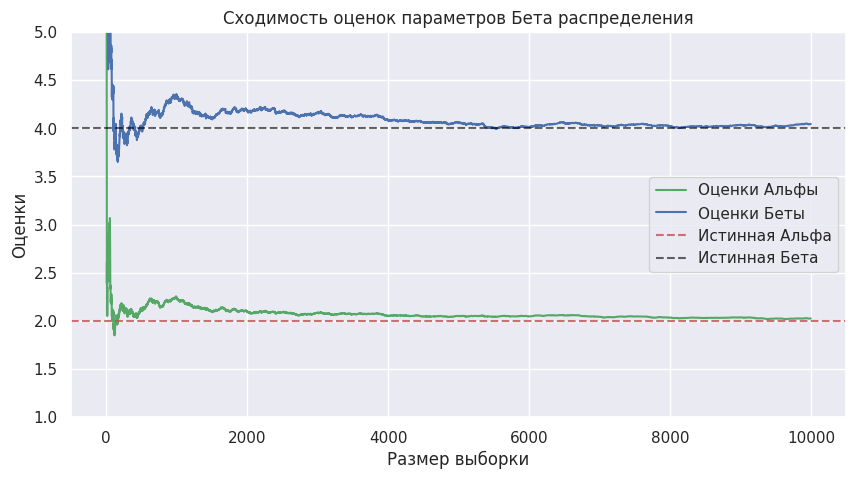

In [111]:
with sns.plotting_context("notebook"):
    plt.figure(figsize=(10, 5))
    plt.plot(beta_alpha_cum_ests, label='Оценки Альфы', color='g')
    plt.plot(beta_beta_cum_ests, label='Оценки Беты', color='b')
    plt.axhline(y=alpha_true, color='r', alpha=0.8, linestyle='--', label='Истинная Альфа')
    plt.axhline(y=beta_true, color='black', alpha=0.6, linestyle='--', label='Истинная Бета')
    plt.title('Сходимость оценок параметров Бета распределения')
    plt.xlabel('Размер выборки')
    plt.ylabel('Оценки')
    plt.ylim((1, 5))
    plt.legend()

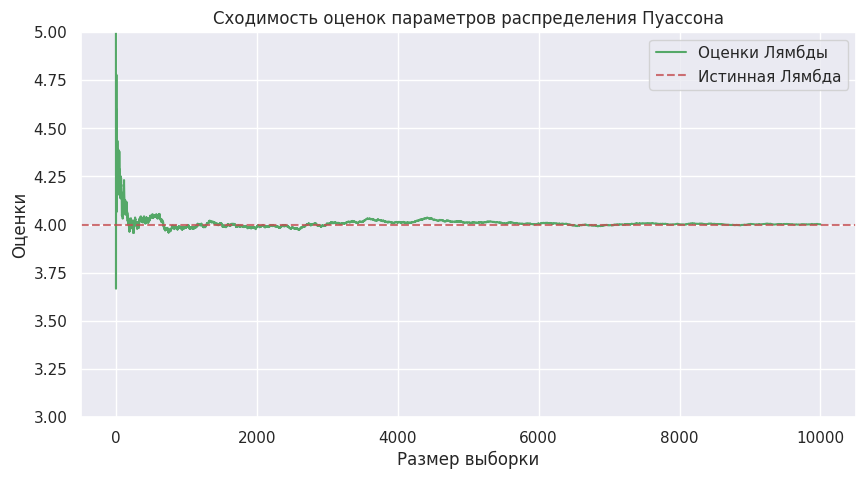

In [112]:
with sns.plotting_context("notebook"):
    plt.figure(figsize=(10, 5))
    plt.plot(poiss_cum_ests, label='Оценки Лямбды', color='g')
    plt.axhline(y=lambda_true, color='r', alpha=0.8, linestyle='--', label='Истинная Лямбда')
    plt.title('Сходимость оценок параметров распределения Пуассона')
    plt.xlabel('Размер выборки')
    plt.ylabel('Оценки')
    plt.ylim((3, 5))
    plt.legend()

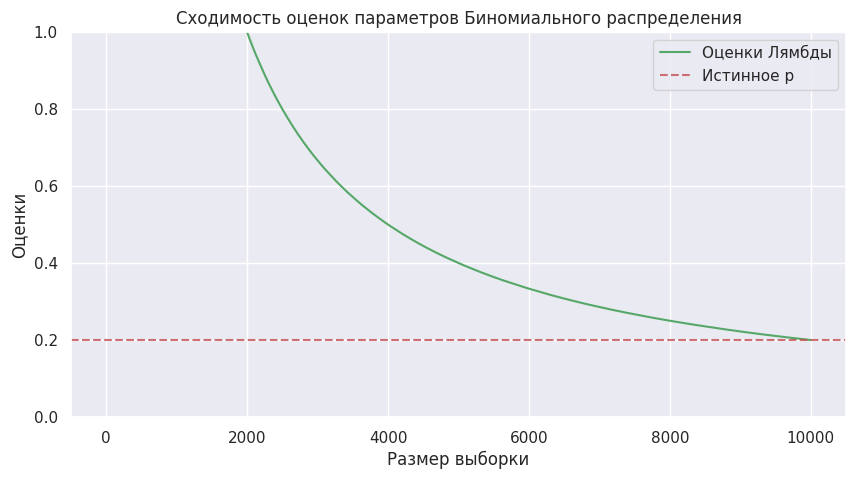

In [114]:
with sns.plotting_context("notebook"):
    plt.figure(figsize=(10, 5))
    plt.plot(bin_cum_ests, label='Оценки Лямбды', color='g')
    plt.axhline(y=p_true, color='r', alpha=0.8, linestyle='--', label='Истинное p')
    plt.title('Сходимость оценок параметров Биномиального распределения')
    plt.xlabel('Размер выборки')
    plt.ylabel('Оценки')
    plt.ylim((0, 1))
    plt.legend()

Графики показывают, что быстрее всех сходятся оценки для Пуассона, а медленнее -- для Биномиального. 

Будут ли оценки состоятельными? Напишите соответствующую теорию.

Ответ: 

Для примера рассмотрим бета-распределение. По ЗБЧ выборочное среднее будет стремиться к матожиданию, а выборочное среднее квадратов -- к сумме дисперссии и квадрата матожидания. А значит, поскольку параметры выражаются исключительно через данные два значения, то по теореме о наследовании сходимости, наши оценки будут состоятельными. Аналогично для оставшихся оценок.

Обоснуйте теоретически, какие скорости сходимости оценок следовало ожидать в этой задаче.

Ответ:

Снова, ЦПТ гарантирует сходимость ЗБЧ за $\frac{1}{\sqrt{n}}$. Поскольку, как мы поняли, все оценки -- это непрервыные функции от величин, сходящихся по ЗБЧ к своим теоретическим значениям, то и оценки буду иметь такую же сходимость.

Сделайте вывод.

**Вывод:**

Итак, мы рассмотрели оценки параметров трех распределений методом моментов, промоделировали сходимость оценок и установили, что они состоятельны и имеют скорость сходимсоти $\frac{1}{\sqrt{n}}$.

## Задача 4. Байесовские оценки (10 баллов)


Для распределения Пуассона и экспоненциального распределения постройте сопряжённое семейство распределений и выведите, как изменяются его параметры после вариационного байесовского вывода (после применения теоремы Байеса):

Просим решить задачу для одного распределения, и только затем для второго, чтобы упростить проверку. Не стройте в одной ячейке объекты, относящиеся к разным распределениям!

Решение:

$1$. Распределение Пуассона. Нужно подобрать априорное распределение, имеющее такие же множители в своей плотности. В данном случае подходит Гамма-распределение.

$q(t) = \frac{\lambda^\alpha t^{\alpha-1}}{\Gamma(\alpha)} e^{-\lambda t} I(t > 0)$. Следовательно, $\rho_{\theta | X}(t | \mathbf{x}) = q(t) \cdot \rho(\mathbf{x} | t) \sim t^{\alpha - 1 + \sum x_i}\cdot e^{-t(\lambda + n)}\cdot I(t > 0)$ -- искомая апостериорная плотность. А апостериорным распределением будет $\Gamma(\alpha + \sum x_i, \lambda +  n)$

Постройте апостериорные плотности для разных выборов априорных параметров (для обоих распределений):

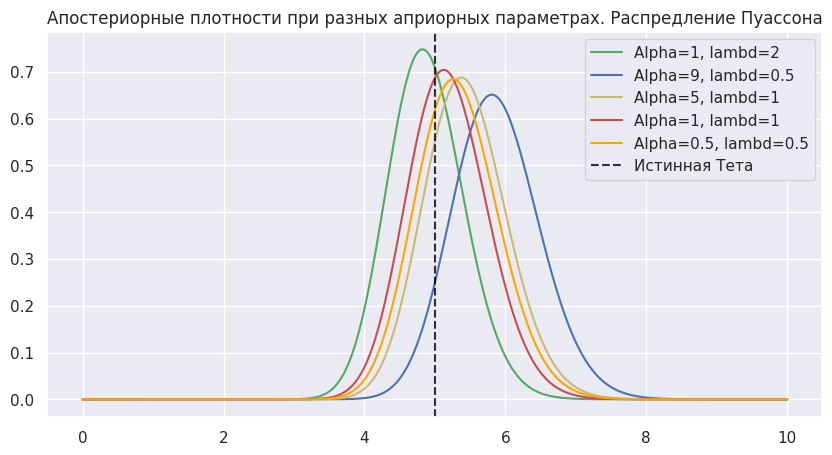

In [315]:
n = 15

theta = 5
sample_poiss = sps.poisson.rvs(mu=theta, size=n)
sum_x = np.sum(sample_poiss)

priors = [
    {'alpha': 1, 'lambd': 2, 'label': 'Alpha=1, lambd=2'},
    {'alpha': 9, 'lambd': 0.5, 'label': 'Alpha=9, lambd=0.5'},
    {'alpha': 5, 'lambd': 1, 'label': 'Alpha=5, lambd=1'},
    {'alpha': 1, 'lambd': 1, 'label': 'Alpha=1, lambd=1'},
    {'alpha': 0.5, 'lambd': 0.5, 'label': 'Alpha=0.5, lambd=0.5'}
]

colors = ['g', 'b', 'y', 'r', 'orange']
with sns.plotting_context("notebook"):
    plt.figure(figsize=(10, 5))
    thetas_grid = np.linspace(0, 10, 500)
    for i in range(5):
        plt.plot(thetas_grid, sps.gamma.pdf(thetas_grid, a=priors[i]['alpha']+sum_x, scale=1/(priors[i]['lambd']+len(sample_poiss))), label=priors[i]['label'], color=colors[i])
    plt.axvline(x=theta, color='black', alpha=0.8, linestyle='--', label='Истинная Тета')
    plt.title('Апостериорные плотности при разных априорных параметрах. Распредление Пуассона')
    plt.legend()

$2$. Экспоненциальное распределение. Аналогичными рассуждениями можно получить, что априорным распределением будет Гамма-распределение. Получим изменение параметров:

$q(t) = \frac{\lambda^\alpha t^{\alpha-1}}{\Gamma(\alpha)} e^{-\lambda t} I(t > 0)$. Следовательно, $\rho_{\theta | X}(t | \mathbf{x}) = q(t) \cdot \rho(\mathbf{x} | t) \sim t^{\alpha - 1 + }\cdot e^{-t(\lambda + \sum x_i)}\cdot I(t > 0)$ -- искомая апостериорная плотность. А апостериорным распределением будет $\Gamma(\alpha + n, \lambda + \sum x_i)$

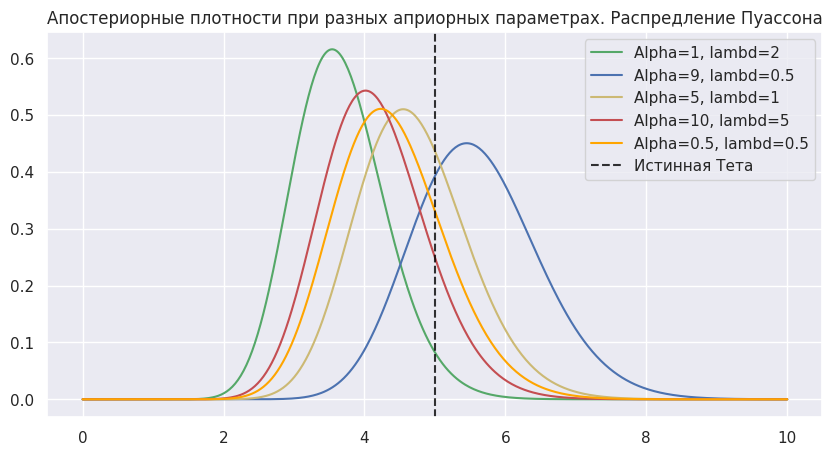

In [337]:
n = 30

theta = 5
sample_exp = sps.expon.rvs(scale=1/theta, size=n)
sum_x = np.sum(sample_exp)

priors = [
    {'alpha': 1, 'lambd': 2, 'label': 'Alpha=1, lambd=2'},
    {'alpha': 9, 'lambd': 0.5, 'label': 'Alpha=9, lambd=0.5'},
    {'alpha': 5, 'lambd': 1, 'label': 'Alpha=5, lambd=1'},
    {'alpha': 1, 'lambd': 1, 'label': 'Alpha=10, lambd=5'},
    {'alpha': 0.5, 'lambd': 0.5, 'label': 'Alpha=0.5, lambd=0.5'}
]

colors = ['g', 'b', 'y', 'r', 'orange']
with sns.plotting_context("notebook"):
    plt.figure(figsize=(10, 5))
    thetas_grid = np.linspace(0, 10, 500)
    for i in range(5):
        plt.plot(thetas_grid, sps.gamma.pdf(thetas_grid, a=priors[i]['alpha']+len(sample_exp), scale=1/(priors[i]['lambd']+sum_x)), label=priors[i]['label'], color=colors[i])
    plt.axvline(x=theta, color='black', alpha=0.8, linestyle='--', label='Истинная Тета')
    plt.title('Апостериорные плотности при разных априорных параметрах. Распредление Пуассона')
    plt.legend()


Сделайте вывод о том, как выбор априорных параметров влияет на апостериорную плотность и как его следует подбирать на практике.

**Вывод:**

Графики показали, что при различных априорных параметрах получаются различные апостериорные плотности. Также, поиграв с размером выборки, я обнаружил, что влияние априорных параметров уменьшается с ростом выборки. Если же выборка небольшая, то их стоит выбирать внимательнее. Хотя бы как гиперпараметр. Например, как показано на графике, взять известный параметр и посмотреть, какая пара априорных параметров лучше подходит.

## Задача 5. Доверительное оценивание. (10 баллов)


Для распределения Лапласа с плотностью $p_{a}(x) = \frac{1}{4}exp(-\frac{|x - a|}{2})$ постройте точный и асимптотический доверительные интервалы. Второй нужно строить на основании ЦПТ.

Ответ:

Асисмтотический ДИ: $(\overline{X}-z_{\frac{1-\gamma}{2}}\cdot \sqrt{\frac{8}{n}},\quad \overline{X}+z_{\frac{1+\gamma}{2}}\cdot \sqrt{\frac{8}{n}}) $. Вывод покажу на сдаче.

Напишите функции вычисления точного, асимптотического и бутстрепного интервала.

In [430]:
def asymptotic_confidence_interval(data, gamma=0.95):
    sample_mean = np.mean(data)
    variance = 8
    std_error = np.sqrt(variance / len(data))
    
    z = norm.ppf((gamma + 1) / 2)
    left = sample_mean - z * std_error
    right = sample_mean + z * std_error
    return (left, right)
    

def bootstrap_confidence_interval(data, gamma=0.95, B=1000):
    bootstrap_means = np.empty(B)
    for b in range(B):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means[b] = np.mean(sample)
    
    lower_percentile = np.percentile(bootstrap_means, 100 * ((1 - gamma) / 2))
    upper_percentile = np.percentile(bootstrap_means, 100 * ((1 + gamma) / 2))
    
    return(lower_percentile, upper_percentile)

На графике в осях (размер выборки, параметр) отрисуйте поведение
 асимптотического, точного и бутстрепного доверительных интервалов уровня доверия 95% (рисуйте интервал как два графика верхней и нижней границы интервала + fill_between между ними). Выставьте прозрачность так, чтобы визуально интервалы были различимы. Размеры выборки выберите так, чтобы график получился информативным (интервалы не схлопнулись быстро).

In [447]:
def simulate_confidence_intervals(a_true=0, alph=0.5, sample_sizes=range(20, 201, 20), num_simulations=100, gamma=0.95, B=1000):
    intervals = {
        'asymptotic_lower': [],
        'asymptotic_upper': [],
        'bootstrap_lower': [],
        'bootstrap_upper': []
    }
    
    for n in sample_sizes:
        asymptotic_lowers = []
        asymptotic_uppers = []
        bootstrap_lowers = []
        bootstrap_uppers = []
        
        for _ in range(num_simulations):  # вот этот кусок кода можно жестко оптимизировть
            data = sps.laplace.rvs(loc=a_true, scale=1/alph, size=n)
            
            asymptotic_ci = asymptotic_confidence_interval(data, gamma)
            asymptotic_lowers.append(asymptotic_ci[0])
            asymptotic_uppers.append(asymptotic_ci[1])
            
            bootstrap_ci = bootstrap_confidence_interval(data, gamma, B)
            bootstrap_lowers.append(bootstrap_ci[0])
            bootstrap_uppers.append(bootstrap_ci[1])
        
        intervals['asymptotic_lower'].append(np.mean(asymptotic_lowers))
        intervals['asymptotic_upper'].append(np.mean(asymptotic_uppers))
        intervals['bootstrap_lower'].append(np.mean(bootstrap_lowers))
        intervals['bootstrap_upper'].append(np.mean(bootstrap_uppers))
    
    return intervals
    

def plot_confidence_intervals(intervals, sample_sizes=range(20, 201, 20), a_true=0):
    with sns.plotting_context("notebook"):
        plt.figure(figsize=(10, 6))
        
        plt.plot(sample_sizes, intervals['asymptotic_lower'], label='Асимптотический низ', color='green')
        plt.plot(sample_sizes, intervals['asymptotic_upper'], label='Асимптотический верх', color='green')
        plt.fill_between(sample_sizes, intervals['asymptotic_lower'], intervals['asymptotic_upper'], color='green', alpha=0.1)
        
        plt.plot(sample_sizes, intervals['bootstrap_lower'], label='Бутстрепный низ', color='red')
        plt.plot(sample_sizes, intervals['bootstrap_upper'], label='Бутстрепный верх', color='red')
        plt.fill_between(sample_sizes, intervals['bootstrap_lower'], intervals['bootstrap_upper'], color='red', alpha=0.1)
        
        plt.axhline(y=a_true, color='black', linestyle='--', label='Истинное значение a')
        
        plt.xlabel('Размер выборки')
        plt.ylabel('a')
        plt.title('ДИ для оценки параметра "a" распределения Лапласа при различных размерах выборки')
        plt.legend()
        plt.grid(True)
    plt.show()


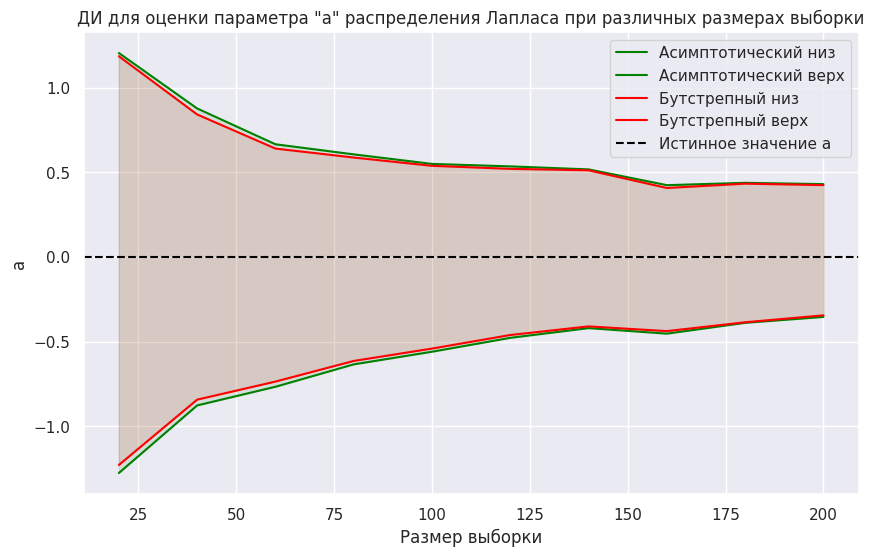

In [448]:
intervals = simulate_confidence_intervals()
plot_confidence_intervals(intervals)

Моделированием по выборкам для фиксированного размера выборки (максимального из графика выше) проверьте, как часто параметр попадает в интервал.

In [453]:
count_asymptotic = 0
count_bootstrap = 0

len_asymptotic = 0
len_bootstrap = 0

for i in range(100):
    sample_laplace = laplace.rvs(loc=0, scale=2, size=200)
    
    asymptotic_ci = asymptotic_confidence_interval(sample_laplace)
    len_asymptotic += asymptotic_ci[1] - asymptotic_ci[0]
    if asymptotic_ci[0] <= 0 and 0 <= asymptotic_ci[1]:
        count_asymptotic += 1
    
    bootstrap_ci = bootstrap_confidence_interval(sample_laplace)
    len_bootstrap += bootstrap_ci[1] - bootstrap_ci[0]
    if bootstrap_ci[0] <= 0 and 0 <= bootstrap_ci[1]:
        count_bootstrap += 1

print(f"Процент попадания параметра в асимптотический ДИ: {count_asymptotic / 100}")
print(f"Процент попадания параметра в бутстрепный ДИ: {count_bootstrap / 100}")
print(f"Средняя длина асимптотического ДИ: {(len_asymptotic / 100):.4f}")
print(f"Средняя длина бутстрепного ДИ: {(len_bootstrap / 100):.4f}")

Процент попадания параметра в асимптотический ДИ: 0.96
Процент попадания параметра в бутстрепный ДИ: 0.95
Средняя длина асимптотического ДИ: 0.7840
Средняя длина бутстрепного ДИ: 0.7753


Сделайте вывод о точности, размере и простоте построения каждого из трёх интервалов.

**Вывод:**

Итак, мы построили асимптотический и бутстрепный ДИ. Показали они примерно одинаковую (и похожую на теоретическую) точность, несмотря на то что в нашем случае качество мерилось на очень небольшой выборке. Тем не менее, хочется отметить, что строить бутстрепну выборку значительно проще с точки зрения умственный затрат. Что касается длин ДИ, то они тоже довольно близки и всего лишь на порядок хуже идеалного сценария, когда длина обратна корню из размера выборки.

## Задача 6. Бутстреп (10 баллов)

Выборка в ячейке ниже представляет собой измерение во времени количество часов, необходимых чтобы решить эту задачу для 10 случайных человек с курса.

In [ ]:
17.68, 13.69, 11.22, 11.05, 13.86, 14.47, 14.50, 13.47, 10.04, 13.10

Вычислите среднее время решения задачи

In [404]:
hours = np.array([17.68, 13.69, 11.22, 11.05, 13.86, 14.47, 14.50, 13.47, 10.04, 13.10])
sample_mean = np.mean(hours)
sample_mean

13.307999999999998

Предложите способ вычисления дисперсии полученной оценки (распределение, из которого пришли данные, неизвестно):

Бутстреп. Состовляем вбыорки из нашего набора данных путем вытягиваний с возварщением. Далее считаем среднее для каждой выборки и для этого массива средних считаем выборочную дисперсию.

In [405]:
B = 1000
bootstrap_means = np.empty(B)

for b in range(B):
    sample = np.random.choice(hours, size=len(hours), replace=True)
    bootstrap_means[b] = np.mean(sample)

bootstrap_variance = np.var(bootstrap_means)
print(f"Дисперсии оценки: {bootstrap_variance:.6f}")

Дисперсии оценки: 0.404255


Предложите доверительный интервал уровня доверия 95% на истинное время выполнения задачи:

In [406]:
lower_percentile = np.percentile(bootstrap_means, 2.5)
upper_percentile = np.percentile(bootstrap_means, 97.5)

print(f"Бутстрэпнный доверительный интервал для среднего: [{lower_percentile:.6f}, {upper_percentile:.6f}]")

Бутстрэпнный доверительный интервал для среднего: [12.067775, 14.524250]


Какое число бутстрепных выборок Вы взяли? Почему?

В бутстрепе можно действовать жадно. А именно, можно брать настолько большое кол-во бутстрепных выборок, насколько позволяет вычислительная мощность. Я взял 1000 (и проверил, что при большем числе выборок улучшений не наблюдается).

Сравните доверительный интервал, который Вы построили методом бутстрепа с асимптотическим доверительным интервалом, построенным с использованием бутстрепной дисперсии. Какой вышел длиннее? Какому Вы бы больше доверились и почему?

In [409]:
sample_std = np.sqrt(bootstrap_variance)
standard_error = sample_std / np.sqrt(len(hours))

z_right = sps.norm.ppf(0.975)
z_left = sps.norm.ppf(0.025)

left = sample_mean - z_critical * standard_error
right = sample_mean + z_critical * standard_error

print(f"Асимптотический доверительный интервал для среднего: [{left:.6f}, {right:.6f}]")

Асимптотический доверительный интервал для среднего: [12.913928, 13.702072]


Длиннее получился ДИ, полученный методом бутстрепа. Но в данном случае я бы доверился именно ему, поскольку он создан для маленьких выборок. А асимптотические доверительные интервалы -- наоборот, для больших.

Сделайте вывод.

**Вывод**

Итак, мы предложили новый метод оценки дисперсии оценок и построения доверительных интервалов и сравнили его с асимптотическим доверительным интервалом. Бутстрепный ДИ, хоть и получился длиннее, но в данном случае полезнее всилу маленькости выборки. 


## Задача 7. Линейная регрессия (20 баллов)

Поговорим о задаче полиномиального приближения. Дан обобщённый многочлен степени 5, измеренный с нормальной независимой ошибкой.

$P(x) = a_0 + a_1x + a_2x^3 + a_3sin(x) + a_4ln(x)$.

Значения многочлена измерили с ошибкой в точках $x_i = $ 1, 2, ..., 20 и обозначили измерения как $y_i$.

Запишите линейную регрессионную модель, при помощи которой можно будет оценить параметры $a_i$.

Ответ:

$Y = X \cdot a + \epsilon$, 
где $
X =
\begin{pmatrix}
1 & x_1 & x_1^3 & \sin(x_1) & \ln(x_1) \\
1 & x_2 & x_2^3 & \sin(x_2) & \ln(x_2) \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
1 & x_{20} & x_{20}^3 & \sin(x_{20}) & \ln(x_{20})
\end{pmatrix}
$

Выберите какие-то ненулевые параметры $a_i$, проведите измерение (добавив нормальную ошибку) и вычислите оценку параметров. Использовать встроенную регрессионную модель ЗАПРЕЩЕНО, все формулы нужно написать самому.

In [536]:
a_true = np.array([13, 7, 25, 20, 4])

x = np.linspace(1, 21, 20)

def P(x, a):
    return a[0] + a[1] * x + a[2] * (x ** 3) + a[3] * np.sin(x) + a[4] * np.log(x)

y_true = P(x, a_true)  # (20,)

noise = sps.norm.rvs(size=20)
y_obs = y_true + noise

X = np.column_stack((
    np.ones(20),
    x,
    x ** 3, 
    np.sin(x),
    np.log(x)
))

a_est = np.linalg.inv(X.T @ X) @ X.T @ y_obs
print("Оценка а:", a_est)
print("Истинные а:", a_true)

Оценка а: [12.07876527  7.07683368 24.99988223 20.19221441  4.02462817]
Истинные а: [13  7 25 20  4]


Постройте доверительные интервалы для параметров $a_i$ и вычислите их:

Решение:

План такой: 

- Найдем оценку дисперсии ошибки;
- По ней получим ковариационную матрицу оценки параметров;
- Извлечем оттуда стардартные ошибки для каждого коэффициента;
- Так как ошибки распределены нормально, то используем квантили распределения Стьюдента;
- И получим доверительные интервалы.

In [537]:
sigma_square_est = np.sum((y_obs - P(x, a_est)) ** 2) / (20 - 5)
cov_matrix = sigma_square_est * np.linalg.inv(X.T @ X)
std_errors = np.sqrt(np.diag(cov_matrix))

t_critical = sps.t.ppf(0.975, 20 - 15)
ci_lower = a_est - t_critical * std_errors
ci_upper = a_est + t_critical * std_errors

print(ci_lower, ci_upper, sep='\n')

[ 9.45471726  6.12886613 24.99876586 19.11552906 -0.18028406]
[14.70281328  8.02480123 25.0009986  21.26889977  8.22954041]


Проверьте гипотезу $a_3 = 0$ о бесполезности параметра 3 при помощи F-критерия (который нужно написать самому) на уровне значимости 0.05. Отвергается ли она?

In [538]:
a_est = np.linalg.inv(X.T @ X) @ X.T @ y_obs
sigma_square_est = np.sum((y_obs - P(x, a_est)) ** 2) / (20 - 5)

T = np.array([0, 0, 0, 1, 0])
tau = 0
B = T @ np.linalg.inv(X.T @ X) @ T.T
m = 1
F = (T @ a_est - tau).T * (1 / B) * (T @ a_est - tau) / sigma_square_est / m
gamma = 0.95
F_critical = sps.f.ppf(gamma, m, 20 - 5)

if F > F_critical:
    print("Отвергаем гипотезу. Параметр небесполезен.")
else:
    print("Не отвергаем гипотезу. Параметр бесполезен.")

Отвергаем гипотезу. Параметр небесполезен.


Теперь положите $a_3 = 0$ и пересчитайте модель. Проверьте гипотезу из прошлого пункта снова. Отвергается ли она теперь?

In [539]:
a_true = np.array([13, 7, 25, 0, 4])
y_true = P(x, a_true)  # (20,)

y_obs = y_true + noise

a_est = np.linalg.inv(X.T @ X) @ X.T @ y_obs
sigma_square_est = np.sum((y_obs - P(x, a_est)) ** 2) / (20 - 5)

T = np.array([0, 0, 0, 1, 0])
tau = 0
B = T @ np.linalg.inv(X.T @ X) @ T.T
m = 1
F = (T @ a_est - tau).T * (1 / B) * (T @ a_est - tau) / sigma_square_est / m
gamma = 0.95
F_critical = sps.f.ppf(gamma, m, 20 - 5)

if F > F_critical:
    print("Отвергаем гипотезу. Параметр небесполезен.")
else:
    print("Не отвергаем гипотезу. Параметр бесполезен.")

Не отвергаем гипотезу. Параметр бесполезен.


**Вывод:**

Итак, F-тест показал, что параметр небесполезен. И, как и ожидалось, при занулении данного параметра он стал бесполезен и критерий это подтвердил. Логично, ведь нулевой параметр едва ли влияет на значение целевого признака.